In [138]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import os

from scipy.signal import savgol_filter
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.cluster import KMeans
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform, expon, reciprocal

In [139]:
PREDICT_STEP = 96
INPUT_STEP = 384
N_FEATURE = 1

In [140]:
# dirs
DATA_DIR = "./load.csv"
TEST_PLOT_DIR = "./test_plots/savgol_xgboost_svm/"
MODEL_FILE_DIR = "./model/savgol_xgboost_svm.keras"
TRAINING_HISTORY_DIR = "./training_history/savgol_xgboost_svm.png"

In [141]:
if not os.path.exists(TEST_PLOT_DIR):
    os.makedirs(TEST_PLOT_DIR)
if not os.path.exists("./model"):
    os.makedirs("./model")
if not os.path.exists("./training_history"):
    os.makedirs("./training_history")


In [142]:
data = pd.read_csv(DATA_DIR)
maxValue = np.max(data['Load'])
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data['Load'].to_numpy().reshape(-1, 1))
print(data_scaled)
data['Load'] = data_scaled.reshape(-1, 1)
# Convert the 'date' column to datetime format
data['Timestamp'] = pd.to_datetime(data['Timestamp'], format='%Y/%m/%d %H:%M')

# Sort the data by date
groups = data.groupby(pd.Grouper(key='Timestamp', freq='D'))

[[0.4454918 ]
 [0.42704918]
 [0.4454918 ]
 ...
 [0.36557377]
 [0.33729508]
 [0.25368852]]


In [143]:
train_df = []
for date, data in groups:
    train_df.append(list(data["Load"]))
train_df = np.array(train_df)

In [144]:
train_df

array([[0.4454918 , 0.42704918, 0.4454918 , ..., 0.37622951, 0.35942623,
        0.39508197],
       [0.29672131, 0.27581967, 0.41188525, ..., 0.2795082 , 0.31147541,
        0.29795082],
       [0.32704918, 0.32704918, 0.29795082, ..., 0.29139344, 0.3       ,
        0.31393443],
       ...,
       [0.26803279, 0.38032787, 0.2647541 , ..., 0.36557377, 0.33729508,
        0.25368852],
       [0.26803279, 0.38032787, 0.2647541 , ..., 0.36557377, 0.33729508,
        0.25368852],
       [0.26803279, 0.38032787, 0.2647541 , ..., 0.36557377, 0.33729508,
        0.25368852]])

In [145]:
display(train_df.shape)

(365, 96)

In [146]:
def create_dataset(data):
    X, y = [], []
    for i in range(9, len(data) - 1):
        last_two_days = data[i-2:i].flatten()
        last_week_same_days = data[i-7-2:i-7].flatten()

        input_data = np.concatenate([last_two_days, last_week_same_days])
        X.append(input_data)

        next_day = data[i+1]
        y.append(next_day)

    return np.array(X), np.array(y)

In [147]:
X, y = create_dataset(train_df)
print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')

X shape: (355, 384)
y shape: (355, 96)


In [148]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [149]:
kmeans = KMeans(n_clusters=4, random_state=10, n_init='auto')
kmeans.fit(X_train)

KMeans(n_clusters=4, n_init='auto', random_state=10)

In [150]:
X_train_label = kmeans.predict(X_train)

X_test_label = kmeans.predict(X_test)

In [151]:
X_train_label

array([3, 1, 1, 0, 3, 0, 3, 1, 2, 3, 3, 3, 1, 2, 3, 1, 0, 3, 1, 0, 0, 3,
       1, 0, 1, 1, 0, 1, 3, 3, 3, 2, 2, 0, 3, 2, 1, 3, 0, 3, 2, 2, 1, 0,
       1, 3, 2, 3, 0, 2, 0, 1, 3, 3, 0, 3, 3, 1, 0, 1, 3, 1, 3, 3, 2, 3,
       1, 1, 2, 2, 0, 0, 3, 3, 1, 3, 0, 3, 3, 3, 1, 3, 3, 1, 2, 1, 0, 2,
       2, 0, 3, 3, 3, 3, 2, 2, 3, 0, 3, 1, 1, 0, 3, 1, 2, 0, 3, 3, 0, 1,
       3, 2, 3, 2, 2, 0, 2, 0, 0, 3, 1, 1, 2, 1, 3, 0, 0, 0, 3, 3, 1, 1,
       3, 0, 3, 2, 2, 2, 1, 3, 0, 0, 0, 3, 2, 2, 3, 3, 1, 2, 1, 3, 2, 3,
       3, 2, 3, 0, 2, 1, 0, 1, 3, 1, 0, 3, 2, 1, 1, 1, 0, 1, 0, 0, 3, 0,
       1, 2, 3, 3, 0, 0, 3, 3, 3, 2, 0, 2, 1, 1, 2, 2, 1, 3, 2, 2, 2, 3,
       0, 0, 2, 0, 0, 0, 3, 2, 3, 3, 1, 0, 2, 1, 2, 2, 0, 0, 2, 2, 3, 2,
       3, 1, 1, 1, 0, 1, 0, 2, 2, 3, 1, 0, 0, 0, 0, 3, 1, 0, 2, 2, 2, 1,
       2, 0, 2, 3, 1, 2, 3, 1, 0, 1, 2, 3, 1, 2, 0, 3, 1, 3, 2, 0, 2, 3,
       1, 2, 3, 1, 3, 2, 0, 2, 0, 1, 3, 0, 2, 1, 3, 3, 2, 0, 3, 2, 3, 0,
       3, 0, 3, 1, 0, 0, 3, 0, 1, 2, 3, 3, 2, 1, 3]

In [152]:
X_test_label

array([0, 3, 0, 2, 1, 0, 1, 1, 2, 3, 3, 2, 1, 2, 3, 1, 2, 2, 1, 3, 3, 0,
       0, 1, 0, 2, 2, 3, 1, 1, 2, 1, 1, 2, 3, 1, 1, 2, 1, 3, 0, 1, 2, 3,
       1, 0, 3, 1, 1, 2, 1, 0, 0, 2], dtype=int32)

In [153]:
k0 = np.where(X_train_label == 0)
k1 = np.where(X_train_label == 1)
k2 = np.where(X_train_label == 2)
k3 = np.where(X_train_label == 3)
X_train_0 = X_train[k0]
X_train_1 = X_train[k1]
X_train_2 = X_train[k2]
X_train_3 = X_train[k3]

y_train_0 = y_train[k0]
y_train_1 = y_train[k1]
y_train_2 = y_train[k2]
y_train_3 = y_train[k3]

k0 = np.where(X_test_label == 0)
k1 = np.where(X_test_label == 1)
k2 = np.where(X_test_label == 2)
k3 = np.where(X_test_label == 3)
X_test_0 = X_test[k0]
X_test_1 = X_test[k1]
X_test_2 = X_test[k2]
X_test_3 = X_test[k3]

y_test_0 = y_test[k0]
y_test_1 = y_test[k1]
y_test_2 = y_test[k2]
y_test_3 = y_test[k3]

print('len k0:', len(y_test_0))
print('len k1:', len(y_test_1))
print('len k2:', len(y_test_2))
print('len k3:', len(y_test_3))

len k0: 10
len k1: 19
len k2: 14
len k3: 11


In [154]:
X_train_filtered_0 = np.array(savgol_filter(X_train_0, 10, 4))
X_train_filtered_1 = np.array(savgol_filter(X_train_1, 10, 4))
X_train_filtered_2 = np.array(savgol_filter(X_train_2, 10, 4))
X_train_filtered_3 = np.array(savgol_filter(X_train_3, 10, 4))

y_train_filtered_0 = np.array(savgol_filter(y_train_0, 10, 4))
y_train_filtered_1 = np.array(savgol_filter(y_train_1, 10, 4))
y_train_filtered_2 = np.array(savgol_filter(y_train_2, 10, 4))
y_train_filtered_3 = np.array(savgol_filter(y_train_3, 10, 4))

X_test_filtered_0 = np.array(savgol_filter(X_test_0, 10, 4))
X_test_filtered_1 = np.array(savgol_filter(X_test_1, 10, 4))
X_test_filtered_2 = np.array(savgol_filter(X_test_2, 10, 4))
X_test_filtered_3 = np.array(savgol_filter(X_test_3, 10, 4))

y_test_filtered_0 = np.array(savgol_filter(y_test_0, 10, 4))
y_test_filtered_1 = np.array(savgol_filter(y_test_1, 10, 4))
y_test_filtered_2 = np.array(savgol_filter(y_test_2, 10, 4))
y_test_filtered_3 = np.array(savgol_filter(y_test_3, 10, 4))

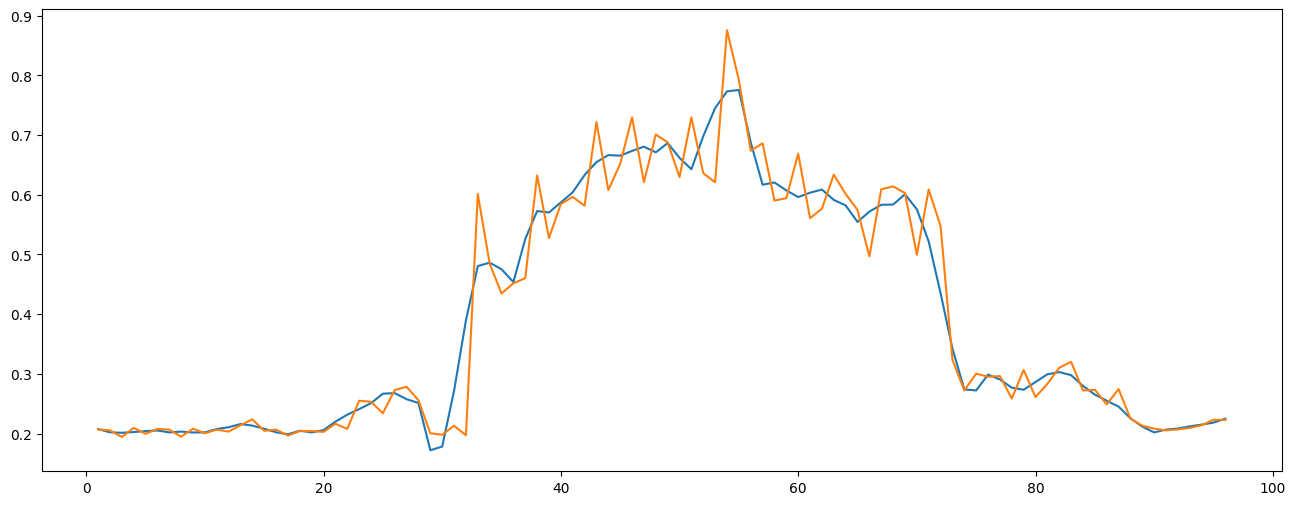

In [155]:
plt.figure(figsize=(16, 6))
X = np.arange(1, 97, 1)
y0 = y_train_filtered_0[0]
y1 = y_train_0[0]
plt.plot(X, y0)
plt.plot(X, y1)
plt.show()

In [156]:
X_train_residual_0 = X_train_0 - X_train_filtered_0
X_train_residual_1 = X_train_1 - X_train_filtered_1
X_train_residual_2 = X_train_2 - X_train_filtered_2
X_train_residual_3 = X_train_3 - X_train_filtered_3

y_train_residual_0 = y_train_0 - y_train_filtered_0
y_train_residual_1 = y_train_1 - y_train_filtered_1
y_train_residual_2 = y_train_2 - y_train_filtered_2
y_train_residual_3 = y_train_3 - y_train_filtered_3


X_test_residual_0 = X_test_0 - X_test_filtered_0
X_test_residual_1 = X_test_1 - X_test_filtered_1
X_test_residual_2 = X_test_2 - X_test_filtered_2
X_test_residual_3 = X_test_3 - X_test_filtered_3

y_test_residual_0 = y_test_0 - y_test_filtered_0
y_test_residual_1 = y_test_1 - y_test_filtered_1
y_test_residual_2 = y_test_2 - y_test_filtered_2
y_test_residual_3 = y_test_3 - y_test_filtered_3


In [157]:
# param_dist = {
#     'max_depth': randint(7, 11),
#     'min_child_weight': randint(7, 12),
#     'learning_rate': uniform(0.01, 0.2),
#     'n_estimators': randint(110, 150)
# }

# xgboost0 = xgb.XGBRegressor(objective='reg:squarederror')
# random_search0 = RandomizedSearchCV(estimator=xgboost0, param_distributions=param_dist, n_iter=50, cv=3, verbose=2, random_state=42, n_jobs=-1)
# random_search0.fit(X_train_residual_0, y_train_residual_0)

# xgboost1 = xgb.XGBRegressor(objective='reg:squarederror',)
# random_search1 = RandomizedSearchCV(estimator=xgboost1, param_distributions=param_dist, n_iter=50, cv=3, verbose=2, random_state=42, n_jobs=-1)
# random_search1.fit(X_train_residual_1, y_train_residual_1)

# xgboost2 = xgb.XGBRegressor(objective='reg:squarederror',)
# random_search2 = RandomizedSearchCV(estimator=xgboost2, param_distributions=param_dist, n_iter=50, cv=3, verbose=2, random_state=42, n_jobs=-1)
# random_search2.fit(X_train_residual_2, y_train_residual_2)

# xgboost3 = xgb.XGBRegressor(objective='reg:squarederror',)
# random_search3 = RandomizedSearchCV(estimator=xgboost3, param_distributions=param_dist, n_iter=50, cv=3, verbose=2, random_state=42, n_jobs=-1)
# random_search3.fit(X_train_residual_3, y_train_residual_3)


# print("random_search0 Best parameters:", random_search0.best_params_)
# print("random_search0 Best score:", random_search0.best_score_)
# print("\n")

# print("random_search1 Best parameters:", random_search1.best_params_)
# print("random_search1 Best score:", random_search1.best_score_)
# print("\n")

# print("random_search2 Best parameters:", random_search2.best_params_)
# print("random_search2 Best score:", random_search2.best_score_)
# print("\n")

# print("random_search3 Best parameters:", random_search3.best_params_)
# print("random_search3 Best score:", random_search3.best_score_)
# print("\n")


# random_search0 Best parameters: {'learning_rate': 0.02631883608004807, 'max_depth': 9, 'min_child_weight': 9, 'n_estimators': 135}
# random_search0 Best score: -0.1972308915781639
# random_search0 Best parameters: {'learning_rate': 0.01110442342472048, 'max_depth': 9, 'min_child_weight': 9, 'n_estimators': 126}
# random_search0 Best score: -0.101390045484775


In [158]:
xgboost0 = xgb.XGBRegressor(
    objective='reg:squarederror',
    learning_rate=0.01110442342472048,
    max_depth=9,
    min_child_weight=9,
    n_estimators=126,
)
xgboost0.fit(X_train_residual_0, y_train_residual_0)

xgboost1 = xgb.XGBRegressor(
    objective='reg:squarederror',
    learning_rate=0.01110442342472048,
    max_depth=9,
    min_child_weight=9,
    n_estimators=126,
)
xgboost1.fit(X_train_residual_1, y_train_residual_1)

xgboost2 = xgb.XGBRegressor(
    objective='reg:squarederror',
    learning_rate=0.01110442342472048,
    max_depth=9,
    min_child_weight=9,
    n_estimators=126,
)
xgboost2.fit(X_train_residual_2, y_train_residual_2)

xgboost3 = xgb.XGBRegressor(
    objective='reg:squarederror',
    learning_rate=0.01110442342472048,
    max_depth=9,
    min_child_weight=9,
    n_estimators=126,
)
xgboost3.fit(X_train_residual_3, y_train_residual_3)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01110442342472048,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=9, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=126, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [159]:
# param_dist = {
#     'estimator__C': reciprocal(0.0001, 0.1),
#     'estimator__epsilon': expon(scale=0.1)
# }

# svr0 = SVR(kernel='rbf')
# multioutput_svr0 = MultiOutputRegressor(svr0)
# random_search0 = RandomizedSearchCV(estimator=multioutput_svr0, param_distributions=param_dist, n_iter=300, cv=4, verbose=2, random_state=42, n_jobs=-1)
# random_search0.fit(X_train_filtered_0, y_train_filtered_0)

# svr1 = SVR(kernel='rbf')
# multioutput_svr1 = MultiOutputRegressor(svr1)
# random_search1 = RandomizedSearchCV(estimator=multioutput_svr1, param_distributions=param_dist, n_iter=300, cv=4, verbose=2, random_state=42, n_jobs=-1)
# random_search1.fit(X_train_filtered_1, y_train_filtered_1)

# svr2 = SVR(kernel='rbf')
# multioutput_svr2 = MultiOutputRegressor(svr2)
# random_search2 = RandomizedSearchCV(estimator=multioutput_svr2, param_distributions=param_dist, n_iter=300, cv=4, verbose=2, random_state=42, n_jobs=-1)
# random_search2.fit(X_train_filtered_2, y_train_filtered_2)

# svr3 = SVR(kernel='rbf')
# multioutput_svr3 = MultiOutputRegressor(svr3)
# random_search3 = RandomizedSearchCV(estimator=multioutput_svr3, param_distributions=param_dist, n_iter=300, cv=4, verbose=2, random_state=42, n_jobs=-1)
# random_search3.fit(X_train_filtered_3, y_train_filtered_3)

# print("random_search0 Best parameters:", random_search0.best_params_)
# print("random_search0 Best score:", random_search0.best_score_)
# print("\n")

# print("random_search1 Best parameters:", random_search1.best_params_)
# print("random_search1 Best score:", random_search1.best_score_)
# print("\n")

# print("random_search2 Best parameters:", random_search2.best_params_)
# print("random_search2 Best score:", random_search2.best_score_)
# print("\n")

# print("random_search3 Best parameters:", random_search3.best_params_)
# print("random_search3 Best score:", random_search3.best_score_)
# print("\n")

# Search 1
# random_search0 Best parameters: {'estimator__C': 0.14290425609432092, 'estimator__epsilon': 0.0757908940625521}
# random_search0 Best score: 0.010465281631274859

# random_search1 Best parameters: {'estimator__C': 0.2946531769463084, 'estimator__epsilon': 0.028800598912658362}
# random_search1 Best score: 0.07539735351261828

# random_search2 Best parameters: {'estimator__C': 0.24217957731734735, 'estimator__epsilon': 0.016475990155667298}
# random_search2 Best score: 0.24463709181800597

# random_search3 Best parameters: {'estimator__C': 0.10815856940648103, 'estimator__epsilon': 0.06323543695829263}
# random_search3 Best score: -0.09922169044601128



In [160]:
svr0 = SVR(kernel='rbf', C=0.14290425609432092, epsilon=0.0757908940625521)
multioutput_svr0 = MultiOutputRegressor(svr0)
multioutput_svr0.fit(X_train_filtered_0, y_train_filtered_0)

svr1 = SVR(kernel='rbf', C=0.2946531769463084, epsilon=0.028800598912658362)
multioutput_svr1 = MultiOutputRegressor(svr1)
multioutput_svr1.fit(X_train_filtered_1, y_train_filtered_1)

svr2 = SVR(kernel='rbf', C=0.24217957731734735, epsilon=0.016475990155667298)
multioutput_svr2 = MultiOutputRegressor(svr2)
multioutput_svr2.fit(X_train_filtered_2, y_train_filtered_2)

svr3 = SVR(kernel='rbf', C=0.10815856940648103, epsilon=0.06323543695829263)
multioutput_svr3 = MultiOutputRegressor(svr3)
multioutput_svr3.fit(X_train_filtered_3, y_train_filtered_3)

MultiOutputRegressor(estimator=SVR(C=0.10815856940648103,
                                   epsilon=0.06323543695829263))

In [161]:
pred_svr0 = multioutput_svr0.predict(X_test_filtered_0)
pred_xgboost0 = xgboost0.predict(X_test_residual_0)

pred_svr1 = multioutput_svr1.predict(X_test_filtered_1)
pred_xgboost1 = xgboost1.predict(X_test_residual_1)

pred_svr2 = multioutput_svr2.predict(X_test_filtered_2)
pred_xgboost2 = xgboost2.predict(X_test_residual_2)

pred_svr3 = multioutput_svr3.predict(X_test_filtered_3)
pred_xgboost3 = xgboost3.predict(X_test_residual_3)

In [162]:
y_pred_0 = pred_svr0 + pred_xgboost0
y_pred_1 = pred_svr1 + pred_xgboost1
y_pred_2 = pred_svr2 + pred_xgboost2
y_pred_3 = pred_svr3 + pred_xgboost3

y_pred = np.concatenate([y_pred_0, y_pred_1, y_pred_2, y_pred_3], axis=0)
y_test_clustered = np.concatenate([y_test_0, y_test_1, y_test_2, y_test_3], axis=0)
loss = mean_squared_error(y_test_clustered, y_pred)

print("-" * 86)
print(f'Testing Loss: {loss:.4f}')
print("-" * 86)

pred_data = scaler.inverse_transform(y_pred)
actual_data = scaler.inverse_transform(y_test_clustered)
for i in range(actual_data.shape[0]):
    plt.figure(figsize=(16, 6))
    X = np.arange(1, actual_data.shape[1]+1, 1)
    y_p = pred_data[i]
    y_a = actual_data[i]
    plt.title(f"Day {i+1} prediction")
    plt.plot(X, y_p, label='Predict')
    plt.plot(X, y_a, label='Actual')
    plt.ylim(0, maxValue)
    plt.xlabel('Time step')
    plt.ylabel('Usage (kWh)')
    plt.legend()
    plt.savefig(TEST_PLOT_DIR+f"Day{i+1}.png")
    plt.close()


    

--------------------------------------------------------------------------------------
Testing Loss: 0.0079
--------------------------------------------------------------------------------------


In [163]:
# save the model
# xgboost
xgboost0.save_model('xgboost0.model')
xgboost1.save_model('xgboost1.model')
xgboost2.save_model('xgboost2.model')
xgboost3.save_model('xgboost3.model')

# svr
from joblib import dump
dump(multioutput_svr0, 'svr0.joblib')
dump(multioutput_svr1, 'svr1.joblib')
dump(multioutput_svr2, 'svr2.joblib')
dump(multioutput_svr3, 'svr3.joblib')

# kMeans
dump(kmeans, 'kmeans.joblib')
dump(scaler, 'scaler.joblib')

/Users/elviswu/miniconda3/envs/tf/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [16:41:57] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


['scaler.joblib']